<a href="https://colab.research.google.com/github/Ilia-Gershen/TYP-project/blob/main/ExperimentWithModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Models Input format testing

Searching for the best input shape for deep learning models for Cryptocurrency  price prediction

Choosing between the input shape of
*   One week (1to1)
*   Two weeks (2to1)
*   Three weeks (3to1)
*   Four weeks (4to1)

Models tested are:


*   LSTM-GRU
*   GRU-LSTM
*   Transformer




The models performance is going to be validated by RMSE, MSE and MAE metrics


*Will continue with model changes in DeepLearningModel file*


#### Importing libraries and dataset

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.nn import functional

In [ ]:
from google.colab import drive #connecting google drive with Database of the project
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the csv made in data preprocessing stage
ETH = pd.read_csv("/content/drive/MyDrive/Database/ETH-preprocessed.csv")
#ETH.sort_values(by = 'Date', ascending = False, inplace = True) #sorting it so on the top are the most recent dates
ETH.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1.181530e+09
1,1,2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,8.070270e+08
2,2,2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,9.499120e+08
3,3,2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,8.008190e+08
4,4,2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1.845680e+09


#### Deviding data into Training Validation and Testing

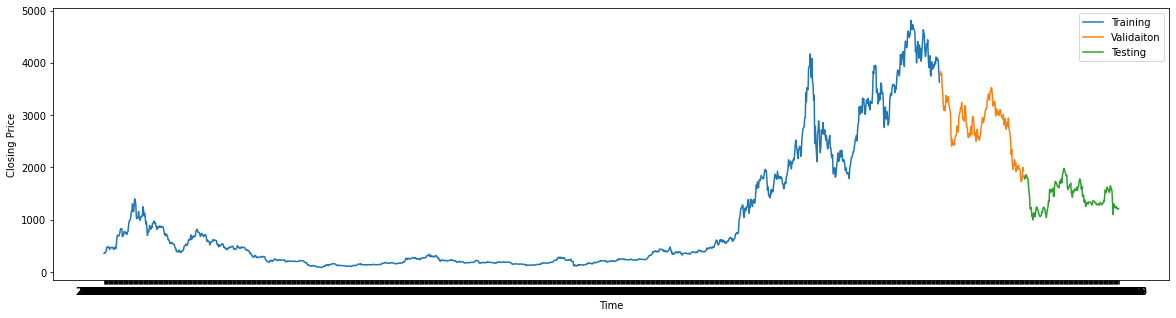

In [ ]:
#Data split for Training Validation and Testing
plt.figure(figsize = (20, 5))
plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
def DatasetFor1to1(Data, Date): #function for creation of traning and testing datasets for the models

  #Data for Training
  #From 2018 to 2022
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  for i in range(0, len(Train_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TrainingData.append(Train_Data[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
    TrainingData.pop(-1)

  TrainingDataX = TrainingData[0 : -1] # taking all but last element
  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 7, 1)) #split into groups of 7


  TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) # split into groups of 7 and keep the order

  # So in the end x is all previous weeks and y is all next weeks

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  for i in range(0, len(Val_Data), 7):
    try:
      ValData.append(Val_Data[i : i + 7])
    except:
      pass

  if len(ValData[-1]) < 7:
    ValData.pop(-1)

  ValDataX = ValData[0 : -1]
  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 7, 1))

  ValDataY = ValData[1 : len(ValData)]
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

  #Data for Testing
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 7):
    try:
      TestData.append(Test_Data[i : i+7])
    except:
      pass

  if len(TestData[-1]) < 7:
    TestData.pop(-1)

  TestDataX = TestData[0 : -1]
  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 7, 1))

  TestDataY = TestData[1 : len(TestData)]
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY


In [ ]:
def DatasetFor2to1(Data, Date): #function for creation of traning and testing datasets for the models

  #Data for Training
  #From 2018 to 2022
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  Train_Data = np.delete(Train_Data, 0)

  #could also take for x i-7 to get the y week and then i+7 to get hole week
  #for y take i+7 and i+14,
  #so the step in that case is going to be 2 weeks
  for i in range(0, len(Train_Data), 21):
    try:
      TrainingDataX.append(Train_Data[i : i+14])
    except:
      TrainingDataX.pop(-1)
      pass
    try:
      TrainingDataY.append(Train_Data[i+14:i+14+7])
    except:
      TrainingDataX.pop(-1)
      TrainingDataY.pop(-1)
      pass

  if len(TrainingDataX[-1]) < 14:
    TrainingDataX.pop(-1)

  if len(TrainingDataY[-1]) < 7:
    TrainingDataY.pop(-1)

  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 14, 1))
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1))

    # So in the end x is all previous weeks and y is all next weeks

    #Data for Validation
    #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-03') & (Data['Date'] < '2022-05-30')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  for i in range(0, len(Val_Data), 21):
    try:
      ValDataX.append(Val_Data[i : i+14])
    except:
      ValDataX.pop(-1)
      pass
    try:
      ValDataY.append(Val_Data[i+14:i+14+7])
    except:
      ValDataX.pop(-1)
      ValDataY.pop(-1)
      pass

  if len(ValDataX[-1]) < 14:
    ValDataX.pop(-1)

  if len(ValDataY[-1]) < 7:
    ValDataY.pop(-1)

  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 14, 1))
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

    #Data for Testing
    #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-06'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 21):
    try:
      TestDataX.append(Test_Data[i : i+14])
    except:
      TestDataX.pop(-1)
      pass
    try:
      TestDataY.append(Test_Data[i+14:i+14+7])
    except:
      TestDataX.pop(-1)
      TestDataY.pop(-1)
      pass

  if len(TestDataX[-1]) < 14:
    TestDataX.pop(-1)

  if len(TestDataY[-1]) < 7:
    TestDataY.pop(-1)

  TestDataX.pop(-1)

  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 14, 1))
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

In [ ]:
def DatasetFor3to1(Data, Date):

  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  Train_Data = np.delete(Train_Data, 0)

  #could also take for x i-7 to get the y week and then i+14 to get hole week
  #for y take i+14 and i+21,
  #so the step in that case is going to be 3 weeks not 4
  for i in range(0, len(Train_Data), 28):

    try:
      TrainingDataX.append(Train_Data[i : i+21])
    except:
      TrainingDataX.pop(-1)
      pass
    try:
      TrainingDataY.append(Train_Data[i+21:i+21+7])
    except:
      TrainingDataX.pop(-1)
      TrainingDataY.pop(-1)
      pass

  if len(TrainingDataX[-1]) < 21:
    TrainingDataX.pop(-1)

  if len(TrainingDataY[-1]) < 7:
    TrainingDataY.pop(-1)

  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 21, 1))
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1))

    #Data for Validation
    #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  for i in range(0, len(Val_Data), 28): #putting in close values data in form of weeks aka 7 days
    try:
      ValDataX.append(Val_Data[i : i+21]) #array of arrays of 7 close prices
    except:
      ValDataX.pop(-1)
      pass
    try:
      ValDataY.append(Val_Data[i+21:i+21+7])
    except:
      ValDataX.pop(-1)
      ValDataY.pop(-1)
      pass

  if len(ValDataX[-1]) < 21:
    ValDataX.pop(-1)

  if len(ValDataY[-1]) < 7:
    ValDataY.pop(-1)

  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 21, 1))
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

    #Data for Testing
    #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 28): #putting in close values data in form of weeks aka 7 days
    try:
      TestDataX.append(Test_Data[i : i+21]) #array of arrays of 7 close prices
    except:
      TestDataX.pop(-1)
      pass
    try:
      TestDataY.append(Test_Data[i+21:i+21+7])
    except:
      TestDataX.pop(-1)
      TestDataY.pop(-1)
      pass

  if len(TestDataX[-1]) < 21:
    TestDataX.pop(-1)

  if len(TestDataY[-1]) < 7:
    TestDataY.pop(-1)

  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 21, 1))
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

In [ ]:
def DatasetFor4to1(Data, Date):

  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  Train_Data = np.delete(Train_Data, 0)

  #could also take for x i-7 to get the y week and then i+21 to get hole week
  #for y take i+21 and i+28,
  #so the step in that case is going to be 4 weeks not 5!
  for i in range(0, len(Train_Data), 35):
    try:
      TrainingDataX.append(Train_Data[i : i+28])
      TrainingDataY.append(Train_Data[i+28:i+28+7])
    except:
      pass

  if len(TrainingDataX[-1]) < 28:
    TrainingDataX.pop(-1)

  if len(TrainingDataY[-1]) < 7:
    TrainingDataY.pop(-1)
    TrainingDataX.pop(-1)

  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 28, 1))
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1))

    #Data for Validation
    #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []


  for i in range(0, len(Val_Data), 35): #putting in close values data in form of weeks aka 7 days
    try:
      ValDataX.append(Val_Data[i : i+28]) #array of arrays of 7 close prices
      ValDataY.append(Val_Data[i+28:i+28+7])
    except:
      pass


  if len(ValDataY[-1]) < 7:
    ValDataY.pop(-1)
    ValDataX.pop(-1)

  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 28, 1))
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

    #Data for Testing
    #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 35): #putting in close values data in form of weeks aka 7 days
    try:
      TestDataX.append(Test_Data[i : i+28]) #array of arrays of 7 close prices
      TestDataY.append(Test_Data[i+28:i+28+7])
    except:
      pass

  if len(TestDataX[-1]) < 28:
    TestDataX.pop(-1)

  if len(TestDataY[-1]) < 7:
    TestDataY.pop(-1)
    TestDataX.pop(-1)

  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 28, 1))
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

#### Plotting functions for models evaluation

In [ ]:
def DrawingTrainAndValLoss(historyDict):
  loss = historyDict["loss"]
  root_mean_squared_error = historyDict["root_mean_squared_error"]
  valLoss = historyDict["val_loss"]
  val_root_mean_squared_error = historyDict["val_root_mean_squared_error"]

  epochs = range(1, len(loss) + 1)

  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.set_figheight(5)
  fig.set_figwidth(15)

  ax1.plot(epochs, loss, label = 'Training Loss')
  ax1.plot(epochs, valLoss, label = 'Validation Loss')
  ax1.set(xlabel = "Epochs", ylabel = "Loss")
  ax1.legend()

  ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
  ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
  ax2.set(xlabel = "Epochs", ylabel = "Loss")
  ax2.legend()

  plt.show()

#### Function for models evaluation

In [ ]:
def CalculateErrors(ETH_Test_Y, ETH_prediction):

  mse = mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction)
  print(f'MSE: {mse}')

  mae = mean_absolute_error(ETH_Test_Y.reshape(-1,7), ETH_prediction)
  print(f'MAE: {mae}')

  rmse = math.sqrt(mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction))
  print(f'RMSE: {rmse}')

  mape = np.mean(np.abs(ETH_Test_Y.reshape(-1,7) - ETH_prediction )/np.abs(ETH_Test_Y.reshape(-1,7))) * 100
  print(f'MAPE: {mape}')

#### LSTM-GRU Models

In [ ]:
def Model1to1():

  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [ ]:
def Model2to1():

  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(200, input_shape = (14,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [ ]:
def Model3to1():

  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(200, input_shape = (21,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [ ]:
def Model4to1():
  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(200, input_shape = (28,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])
  return model

In [ ]:
model1to1 = Model1to1()
model2to1 = Model2to1()
model3to1 = Model3to1()
model4to1 = Model4to1()

##### Model 1 to 1 LSTM-GRU

In [ ]:
def scheduler1to1(epoch):
  if epoch <= 100:
    lrate = epoch * (10 ** -6)
  else:
    lrate = 0.00001

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler1to1)

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor1to1(ETH, '2021-11-20')

ETH1to1Model = Model1to1()
ETH1to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH1to1Hist = ETH1to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/200
7/7 [==============================] - 3s 107ms/step - loss: 2177351.0000 - root_mean_squared_error: 1475.5850 - val_loss: 7869590.5000 - val_root_mean_squared_error: 2805.2791 - lr: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 42ms/step - loss: 2177002.2500 - root_mean_squared_error: 1475.4668 - val_loss: 7867338.5000 - val_root_mean_squared_error: 2804.8774 - lr: 1.0000e-06
Epoch 3/200
7/7 [==============================] - 0s 44ms/step - loss: 2175394.7500 - root_mean_squared_error: 1474.9220 - val_loss: 7863244.0000 - val_root_mean_squared_error: 2804.1477 - lr: 2.0000e-06
Epoch 4/200
7/7 [==============================] - 0s 49ms/step - loss: 2173368.7500 - root_mean_squared_error: 1474.2349 - val_loss: 7849118.5000 - val_root_mean_squared_error: 2801.6279 - lr: 3.0000e-06
Epoch 5/200
7/7 [==============================] - 0s 42ms/step - loss: 2170600.5000 - root_mean_squared_error: 1473.2958 - val_loss: 7838877.5000 - val_root_mean_squared_error: 2

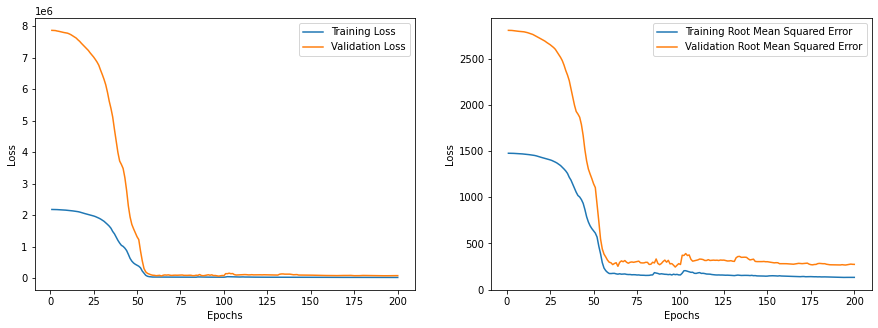

In [ ]:
DrawingTrainAndValLoss(ETH1to1Hist.history)

1/1 [==============================] - 0s 23ms/step
MSE: 31126.224316639644
MAE: 130.29565846108306
RMSE: 176.42625744667274
MAPE: 9.419962040709711


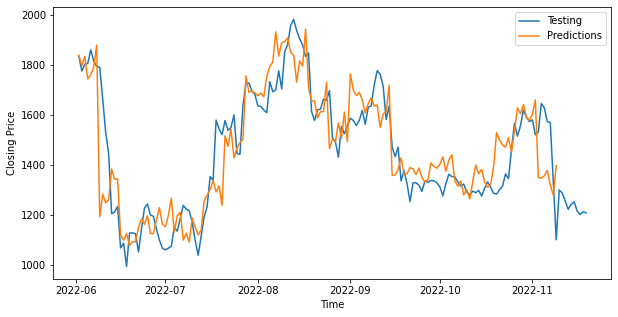

In [ ]:
ETH_prediction = ETH1to1Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)


##### Model 2 to 1 LSTM-GRU


###### Learning rate

In [ ]:
def scheduler(epoch):

  if epoch < 100:
    lrate = 150 * (10 ** -6)
  else:
    lrate = 90 * (10 ** -6)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

###### Training and testing

In [ ]:
ETH["Date"] = pd.to_datetime(ETH["Date"])

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor2to1(ETH, '2021-11-20')


In [ ]:
ETH2to1Model = Model2to1()
ETH2to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH2to1Hist = ETH2to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 400, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/400
3/3 [==============================] - 3s 286ms/step - loss: 2052922.6250 - root_mean_squared_error: 1432.8024 - val_loss: 7325207.0000 - val_root_mean_squared_error: 2706.5120 - lr: 1.5000e-04
Epoch 2/400
3/3 [==============================] - 0s 78ms/step - loss: 2009202.2500 - root_mean_squared_error: 1417.4633 - val_loss: 7222098.5000 - val_root_mean_squared_error: 2687.3962 - lr: 1.5000e-04
Epoch 3/400
3/3 [==============================] - 0s 80ms/step - loss: 1903710.6250 - root_mean_squared_error: 1379.7501 - val_loss: 6523866.5000 - val_root_mean_squared_error: 2554.1863 - lr: 1.5000e-04
Epoch 4/400
3/3 [==============================] - 0s 76ms/step - loss: 1901109.6250 - root_mean_squared_error: 1378.8074 - val_loss: 6568968.0000 - val_root_mean_squared_error: 2563.0000 - lr: 1.5000e-04
Epoch 5/400
3/3 [==============================] - 0s 75ms/step - loss: 1755628.3750 - root_mean_squared_error: 1325.0012 - val_loss: 6207131.0000 - val_root_mean_squared_error: 2

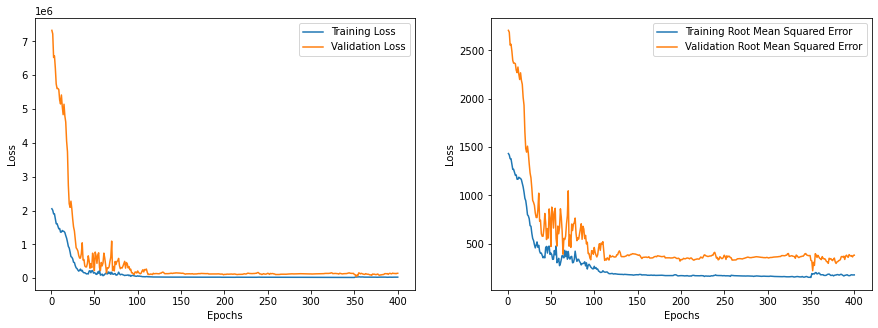

In [ ]:
DrawingTrainAndValLoss(ETH2to1Hist.history)

1/1 [==============================] - 0s 314ms/step


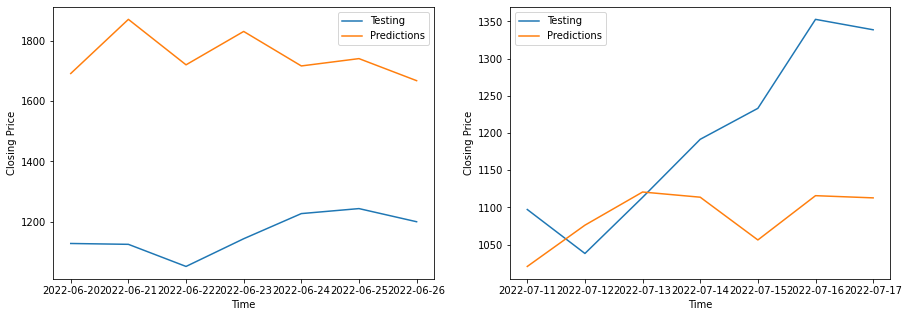

In [ ]:
ETH_prediction = ETH2to1Model.predict(ETH_Test_X)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH['Close'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], label = 'Testing')
ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH_prediction[0].reshape(-1), label = 'Predictions')
ax1.set(xlabel = "Time", ylabel = "Closing Price")
ax1.legend()

ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH['Close'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], label = 'Testing')
ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH_prediction[1].reshape(-1), label = 'Predictions')
ax2.set(xlabel = "Time", ylabel = "Closing Price")
ax2.legend()

plt.show()

In [ ]:
CalculateErrors(ETH_Test_Y, ETH_prediction)

MSE: 86199.53078133214
MAE: 238.89430200669645
RMSE: 293.5975660344141
MAPE: 17.810308795102543


##### Model 3 to 1 LSTM-GRU

In [ ]:
def scheduler3to1(epoch):

  if epoch < 150:
    lrate = 170 * (10 ** -6)
  else:
    lrate = 90 * (10 ** -6)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler3to1)

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor3to1(ETH, '2021-11-20')

ETH3to1Model = Model3to1()
ETH3to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH3to1Hist = ETH3to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 400, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/400
2/2 [==============================] - 4s 441ms/step - loss: 2136652.5000 - root_mean_squared_error: 1461.7292 - val_loss: 6849840.0000 - val_root_mean_squared_error: 2617.2200 - lr: 1.7000e-04
Epoch 2/400
2/2 [==============================] - 0s 84ms/step - loss: 2084735.2500 - root_mean_squared_error: 1443.8612 - val_loss: 6701946.5000 - val_root_mean_squared_error: 2588.8120 - lr: 1.7000e-04
Epoch 3/400
2/2 [==============================] - 0s 92ms/step - loss: 2044058.6250 - root_mean_squared_error: 1429.7058 - val_loss: 6625540.0000 - val_root_mean_squared_error: 2574.0125 - lr: 1.7000e-04
Epoch 4/400
2/2 [==============================] - 0s 91ms/step - loss: 2051638.3750 - root_mean_squared_error: 1432.3541 - val_loss: 6603574.5000 - val_root_mean_squared_error: 2569.7422 - lr: 1.7000e-04
Epoch 5/400
2/2 [==============================] - 0s 98ms/step - loss: 2029279.3750 - root_mean_squared_error: 1424.5278 - val_loss: 6467108.5000 - val_root_mean_squared_error: 2

###### Training and testing

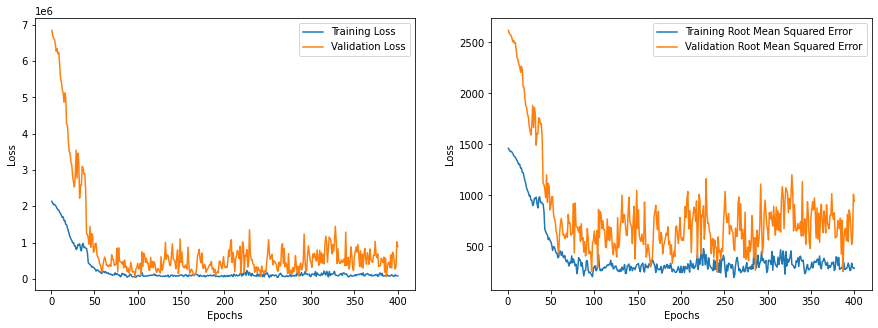

In [ ]:
DrawingTrainAndValLoss(ETH3to1Hist.history)

1/1 [==============================] - 0s 273ms/step


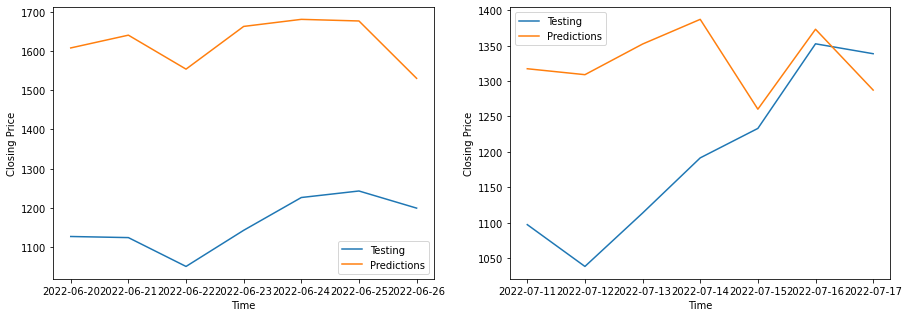

MSE: 115723.1185328036
MAE: 306.8904128169643
RMSE: 340.18100848343016
MAPE: 22.899711854478184


In [ ]:
ETH_prediction = ETH3to1Model.predict(ETH_Test_X)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH['Close'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], label = 'Testing')
ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH_prediction[0].reshape(-1), label = 'Predictions')
ax1.set(xlabel = "Time", ylabel = "Closing Price")
ax1.legend()

ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH['Close'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], label = 'Testing')
ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH_prediction[1].reshape(-1), label = 'Predictions')
ax2.set(xlabel = "Time", ylabel = "Closing Price")
ax2.legend()

plt.show()

CalculateErrors(ETH_Test_Y, ETH_prediction)

##### Model 4 to 1 LSTM-GRU


In [ ]:
def scheduler4to1(epoch):

  #if epoch < 150:
   # lrate = 120 * (10 ** -6)
  #else:
   # lrate = 50 * (10 ** -6)

  if epoch <= 100:
    lrate = 100 * (10 ** -6)
  else:
    lrate = 20 * (10 ** -6)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler4to1)

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor4to1(ETH, '2021-11-20')

ETH4to1Model = Model4to1()
ETH4to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH4to1Hist = ETH4to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 400, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

Epoch 1/400
2/2 [==============================] - 3s 412ms/step - loss: 1854229.0000 - root_mean_squared_error: 1361.7007 - val_loss: 5304209.0000 - val_root_mean_squared_error: 2303.0867 - lr: 1.0000e-04
Epoch 2/400
2/2 [==============================] - 0s 98ms/step - loss: 1733812.2500 - root_mean_squared_error: 1316.7430 - val_loss: 5041564.0000 - val_root_mean_squared_error: 2245.3428 - lr: 1.0000e-04
Epoch 3/400
2/2 [==============================] - 0s 107ms/step - loss: 1539870.6250 - root_mean_squared_error: 1240.9153 - val_loss: 4336352.5000 - val_root_mean_squared_error: 2082.3911 - lr: 1.0000e-04
Epoch 4/400
2/2 [==============================] - 0s 95ms/step - loss: 1625238.5000 - root_mean_squared_error: 1274.8484 - val_loss: 5535682.5000 - val_root_mean_squared_error: 2352.8032 - lr: 1.0000e-04
Epoch 5/400
2/2 [==============================] - 0s 98ms/step - loss: 1689741.8750 - root_mean_squared_error: 1299.9008 - val_loss: 5338283.5000 - val_root_mean_squared_error: 

###### Training and testing

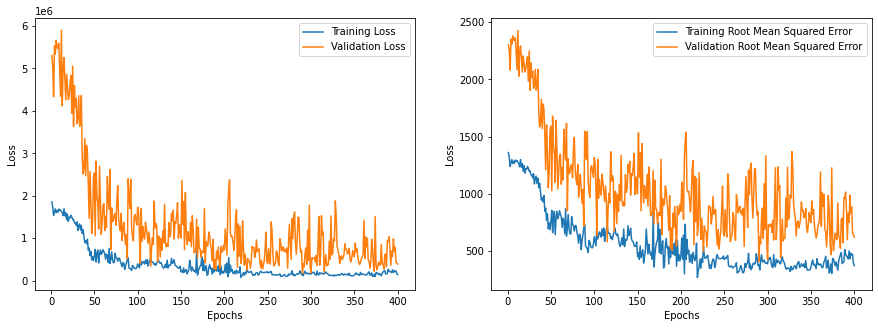

In [ ]:
DrawingTrainAndValLoss(ETH4to1Hist.history)

1/1 [==============================] - 0s 249ms/step


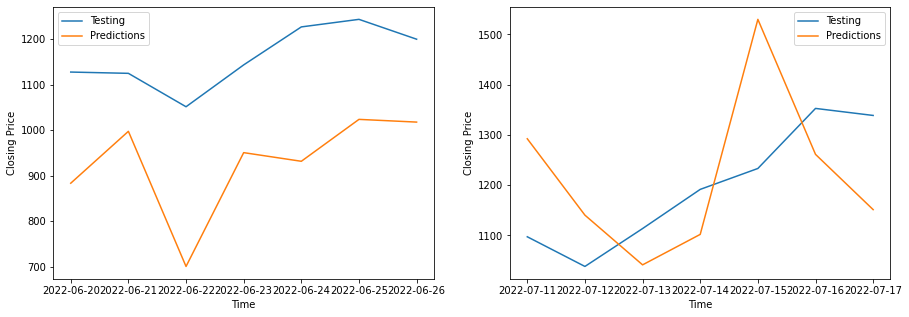

MSE: 138802.16451155237
MAE: 332.7785600834264
RMSE: 372.5616251193249
MAPE: 22.09278051534158


In [ ]:
ETH_prediction = ETH4to1Model.predict(ETH_Test_X)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH['Close'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], label = 'Testing')
ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH_prediction[0].reshape(-1), label = 'Predictions')
ax1.set(xlabel = "Time", ylabel = "Closing Price")
ax1.legend()

ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH['Close'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], label = 'Testing')
ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH_prediction[1].reshape(-1), label = 'Predictions')
ax2.set(xlabel = "Time", ylabel = "Closing Price")
ax2.legend()

plt.show()

CalculateErrors(ETH_Test_Y, ETH_prediction)

#### GRU-LSTM Models

In [ ]:
def Model1to1():

  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.GRU(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

def Model2to1():

  model = tf.keras.models.Sequential([
      tf.keras.layers.GRU(200, input_shape = (14,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

def Model3to1():

  model = tf.keras.models.Sequential([
      tf.keras.layers.GRU(200, input_shape = (21,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

def Model4to1():
  model = tf.keras.models.Sequential([
      tf.keras.layers.GRU(200, input_shape = (28,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])
  return model

model1to1 = Model1to1()
model2to1 = Model2to1()
model3to1 = Model3to1()
model4to1 = Model4to1()

##### Model 1 to 1 GRU-LSTM

Epoch 1/200
7/7 [==============================] - 3s 109ms/step - loss: 2185150.5000 - root_mean_squared_error: 1478.2255 - val_loss: 7896936.0000 - val_root_mean_squared_error: 2810.1489 - lr: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 45ms/step - loss: 2184971.0000 - root_mean_squared_error: 1478.1648 - val_loss: 7895330.5000 - val_root_mean_squared_error: 2809.8633 - lr: 1.0000e-06
Epoch 3/200
7/7 [==============================] - 0s 43ms/step - loss: 2184478.2500 - root_mean_squared_error: 1477.9979 - val_loss: 7891697.0000 - val_root_mean_squared_error: 2809.2166 - lr: 2.0000e-06
Epoch 4/200
7/7 [==============================] - 0s 46ms/step - loss: 2183118.0000 - root_mean_squared_error: 1477.5377 - val_loss: 7887031.0000 - val_root_mean_squared_error: 2808.3857 - lr: 3.0000e-06
Epoch 5/200
7/7 [==============================] - 0s 44ms/step - loss: 2181691.2500 - root_mean_squared_error: 1477.0551 - val_loss: 7882720.0000 - val_root_mean_squared_error: 2

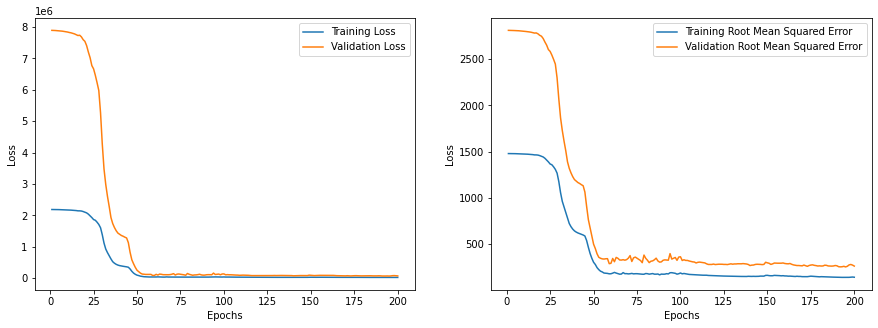

In [ ]:
def scheduler1to1(epoch):
  if epoch <= 100:
    lrate = epoch * (10 ** -6)
  else:
    lrate = 0.00001

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler1to1)

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor1to1(ETH, '2021-11-20')

ETH1to1Model = Model1to1()
ETH1to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH1to1Hist = ETH1to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH1to1Hist.history)

1/1 [==============================] - 0s 289ms/step
MSE: 38166.41837776864
MAE: 141.44211854930126
RMSE: 195.3622747046334
MAPE: 10.226085723354206


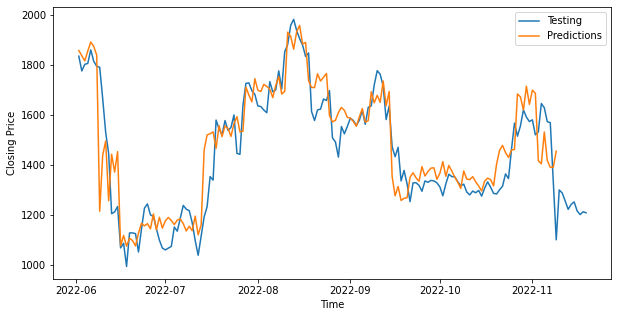

In [ ]:
ETH_prediction = ETH1to1Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

##### Model 2 to 1 GRU-LSTM

Epoch 1/400
3/3 [==============================] - 3s 225ms/step - loss: 2100217.7500 - root_mean_squared_error: 1449.2128 - val_loss: 7559299.0000 - val_root_mean_squared_error: 2749.4180 - lr: 1.5000e-04
Epoch 2/400
3/3 [==============================] - 0s 66ms/step - loss: 2060347.0000 - root_mean_squared_error: 1435.3910 - val_loss: 7464464.0000 - val_root_mean_squared_error: 2732.1169 - lr: 1.5000e-04
Epoch 3/400
3/3 [==============================] - 0s 59ms/step - loss: 2038728.7500 - root_mean_squared_error: 1427.8406 - val_loss: 7401725.0000 - val_root_mean_squared_error: 2720.6113 - lr: 1.5000e-04
Epoch 4/400
3/3 [==============================] - 0s 63ms/step - loss: 2016239.1250 - root_mean_squared_error: 1419.9434 - val_loss: 7306731.5000 - val_root_mean_squared_error: 2703.0967 - lr: 1.5000e-04
Epoch 5/400
3/3 [==============================] - 0s 59ms/step - loss: 1990224.2500 - root_mean_squared_error: 1410.7532 - val_loss: 7238544.0000 - val_root_mean_squared_error: 2

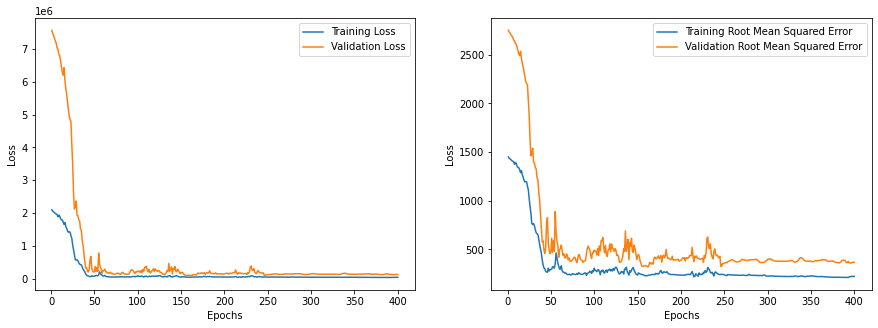

In [ ]:
def scheduler(epoch):

  if epoch < 100:
    lrate = 150 * (10 ** -6)
  else:
    lrate = 90 * (10 ** -6)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH["Date"] = pd.to_datetime(ETH["Date"])

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor2to1(ETH, '2021-11-20')

ETH2to1Model = Model2to1()
ETH2to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH2to1Hist = ETH2to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 400, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH2to1Hist.history)

1/1 [==============================] - 0s 341ms/step


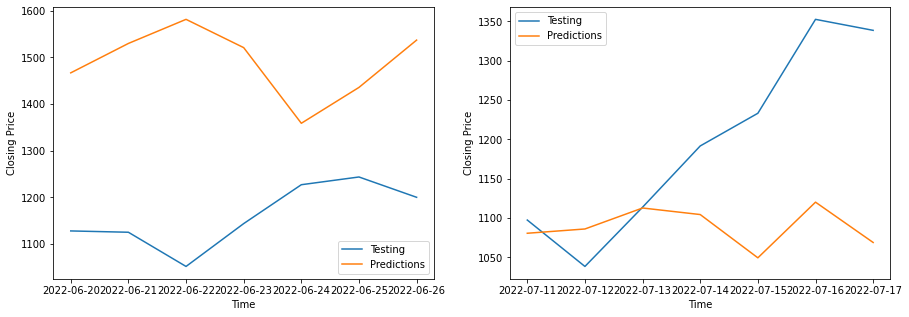

MSE: 42942.338524691586
MAE: 161.26316367570158
RMSE: 207.22533272911298
MAPE: 11.765086122523039


In [ ]:
ETH_prediction = ETH2to1Model.predict(ETH_Test_X)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH['Close'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], label = 'Testing')
ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH_prediction[0].reshape(-1), label = 'Predictions')
ax1.set(xlabel = "Time", ylabel = "Closing Price")
ax1.legend()

ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH['Close'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], label = 'Testing')
ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH_prediction[1].reshape(-1), label = 'Predictions')
ax2.set(xlabel = "Time", ylabel = "Closing Price")
ax2.legend()

plt.show()

CalculateErrors(ETH_Test_Y, ETH_prediction)

##### Model 3 to 1 GRU-LSTM

Epoch 1/400
2/2 [==============================] - 4s 415ms/step - loss: 2097735.2500 - root_mean_squared_error: 1448.3561 - val_loss: 6638440.0000 - val_root_mean_squared_error: 2576.5171 - lr: 1.7000e-04
Epoch 2/400
2/2 [==============================] - 0s 99ms/step - loss: 2078078.6250 - root_mean_squared_error: 1441.5543 - val_loss: 6487981.5000 - val_root_mean_squared_error: 2547.1519 - lr: 1.7000e-04
Epoch 3/400
2/2 [==============================] - 0s 98ms/step - loss: 2028446.2500 - root_mean_squared_error: 1424.2354 - val_loss: 6564953.5000 - val_root_mean_squared_error: 2562.2166 - lr: 1.7000e-04
Epoch 4/400
2/2 [==============================] - 0s 103ms/step - loss: 2002314.3750 - root_mean_squared_error: 1415.0316 - val_loss: 6550703.0000 - val_root_mean_squared_error: 2559.4341 - lr: 1.7000e-04
Epoch 5/400
2/2 [==============================] - 0s 101ms/step - loss: 2021390.6250 - root_mean_squared_error: 1421.7561 - val_loss: 6644982.0000 - val_root_mean_squared_error:

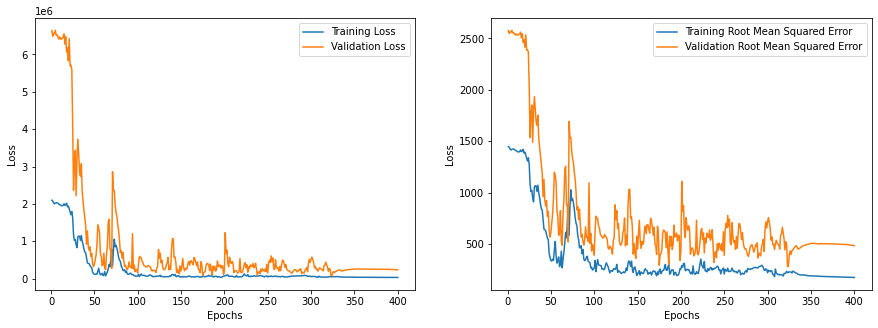

In [ ]:
def scheduler3to1(epoch):

  if epoch < 150:
    lrate = 170 * (10 ** -6)
  else:
    lrate = 90 * (10 ** -6)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler3to1)

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor3to1(ETH, '2021-11-20')

ETH3to1Model = Model3to1()
ETH3to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH3to1Hist = ETH3to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 400, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH3to1Hist.history)

1/1 [==============================] - 0s 273ms/step


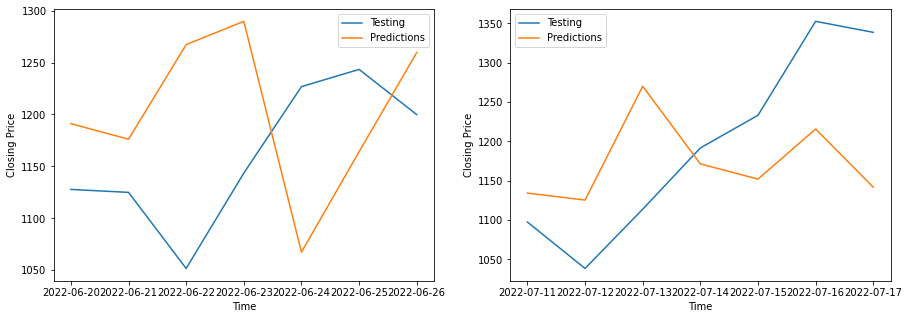

MSE: 55204.4697995594
MAE: 195.83992804129463
RMSE: 234.95631466202266
MAPE: 13.76326039350923


In [ ]:
ETH_prediction = ETH3to1Model.predict(ETH_Test_X)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH['Close'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], label = 'Testing')
ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH_prediction[0].reshape(-1), label = 'Predictions')
ax1.set(xlabel = "Time", ylabel = "Closing Price")
ax1.legend()

ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH['Close'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], label = 'Testing')
ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH_prediction[1].reshape(-1), label = 'Predictions')
ax2.set(xlabel = "Time", ylabel = "Closing Price")
ax2.legend()

plt.show()

CalculateErrors(ETH_Test_Y, ETH_prediction)

##### Model 4 to 1 GRU-LSTM

Epoch 1/400
2/2 [==============================] - 3s 422ms/step - loss: 1952501.3750 - root_mean_squared_error: 1397.3192 - val_loss: 6564568.5000 - val_root_mean_squared_error: 2562.1414 - lr: 1.0000e-04
Epoch 2/400
2/2 [==============================] - 0s 102ms/step - loss: 1929750.2500 - root_mean_squared_error: 1389.1544 - val_loss: 6384898.0000 - val_root_mean_squared_error: 2526.8354 - lr: 1.0000e-04
Epoch 3/400
2/2 [==============================] - 0s 104ms/step - loss: 1944520.0000 - root_mean_squared_error: 1394.4604 - val_loss: 6465921.0000 - val_root_mean_squared_error: 2542.8176 - lr: 1.0000e-04
Epoch 4/400
2/2 [==============================] - 0s 111ms/step - loss: 1962774.1250 - root_mean_squared_error: 1400.9905 - val_loss: 6447821.5000 - val_root_mean_squared_error: 2539.2561 - lr: 1.0000e-04
Epoch 5/400
2/2 [==============================] - 0s 108ms/step - loss: 1931804.7500 - root_mean_squared_error: 1389.8938 - val_loss: 6400856.0000 - val_root_mean_squared_erro

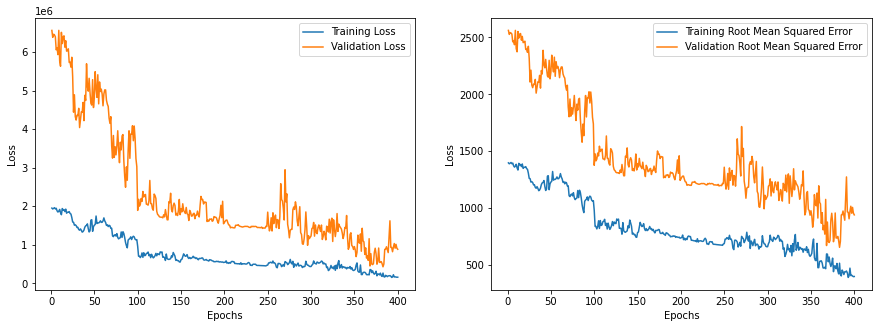

In [ ]:
def scheduler4to1(epoch):

  #if epoch < 150:
   # lrate = 120 * (10 ** -6)
  #else:
   # lrate = 50 * (10 ** -6)

  if epoch <= 100:
    lrate = 100 * (10 ** -6)
  else:
    lrate = 20 * (10 ** -6)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler4to1)

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor4to1(ETH, '2021-11-20')

ETH4to1Model = Model4to1()
ETH4to1Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH4to1Hist = ETH4to1Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 400, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH4to1Hist.history)

1/1 [==============================] - 0s 270ms/step


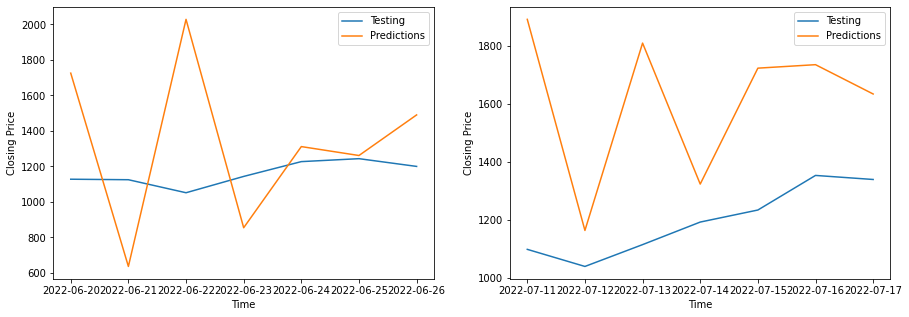

MSE: 151917.7116256084
MAE: 307.30797038532364
RMSE: 389.7662268919774
MAPE: 22.489792590697874


In [ ]:
ETH_prediction = ETH4to1Model.predict(ETH_Test_X)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH['Close'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], label = 'Testing')
ax1.plot(ETH['Date'][(ETH['Date'] >= '2022-06-20')&(ETH['Date'] <= '2022-06-26')], ETH_prediction[0].reshape(-1), label = 'Predictions')
ax1.set(xlabel = "Time", ylabel = "Closing Price")
ax1.legend()

ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH['Close'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], label = 'Testing')
ax2.plot(ETH['Date'][(ETH['Date'] >= '2022-07-11')&(ETH['Date'] <= '2022-07-17')], ETH_prediction[1].reshape(-1), label = 'Predictions')
ax2.set(xlabel = "Time", ylabel = "Closing Price")
ax2.legend()

plt.show()

CalculateErrors(ETH_Test_Y,ETH_prediction)

#### As the result of the experiment the best  input shape for the model in our case is 1 to 1 or one week data in one week prediction out.

So the model 1to1 will be changed and compared in *DeepLearningModel*

#### Transformer

##### The final version
Where everything from above put together and trained

In [ ]:
def errorForTransformer(true_values, pred):

  #MSE
  MSE = np.square(np.subtract(true_values, pred)).mean()

  #MAE
  sum = 0
  for i in range(len(true_values)):
    sum += abs(true_values[i] - pred[i])

  MAE = sum/len(true_values)

  #RMSE
  RMSE = math.sqrt(MSE)

  #MAPE
  holder = 0
  for i in range(len(true_values)):
    percentErr = abs((true_values[i] - pred[i]) / true_values[i])
    holder += percentErr

  MAPE = holder / len(true_values)

  print("MSE: ", MSE)
  print("MAE: ", MAE)
  print("RMSE: ", RMSE)
  print("MAPE: ", round(MAPE, 2))
  print("MAPE: ", round(MAPE*100, 2), "%") # MAPE in percentage representation

#### Dataset function with all forms of normalisation to apply to transformer model

In [ ]:
def Dataset(Data, input): #function for creation of traning and testing datasets for the models
#input 1 for scaling to a range
#input 2 for Log scaling
#input 3 for z-score
  #Swap date into right format
  ETH["Date"] = pd.to_datetime(ETH["Date"])

  #Train_DataY = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()
  #Data for Training
  #From 2018 to 2022
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  #0+
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Train_Data_Val = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Train_Data_Test = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()


  Train_Data = np.append(Train_Data,  Train_Data_Val)

  Train_Data = np.append(Train_Data,  Train_Data_Test)

  if input == 1:
    #Normalize by scaling to a range
    minn = min(Train_Data)
    maxx = max(Train_Data)
    for i in range(len(Train_Data)):
      new = (Train_Data[i]-minn)/(maxx-minn)
      Train_Data[i] = new


  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Train_Data)):
      Train_Data[i] = math.log(Train_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Train_Data:
      sum += i
    mean = sum/len(Train_Data)
    standardDev = np.std(Train_Data)
    for i in range(len(Train_Data)):
      Train_Data[i] = (Train_Data[i] - mean)/standardDev


  Train_DataY = Train_Data[7:]

  Train_DataY = Train_DataY.reshape(1, -1)

  Train_Data = Train_Data.reshape(1, -1) #normalized data holding all the values for train and test

  #The training input for the model in TrainingDataX
  TrainingDataXWV = np.zeros((213, 7, 1))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataXWV[i,l,0] = Train_Data[0,counter]
      counter += 1

  TrainingDataYWV = np.zeros((213, 7, 1))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataYWV[i,l,0] = Train_DataY[0,counter]
      counter += 1

  TrainingDataX = TrainingDataXWV
  TrainingDataY = TrainingDataYWV


  #Data for Validation
  #From 2022 to 2022-06
  #Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  #The training input for the model in TrainingDataX
  ValDataXWV = np.zeros((20, 7, 1))

  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataXWV[i,l,0] = Train_Data[0,1502+counter]
      counter += 1

  ValDataX = ValDataXWV

  ValDataYWV = np.zeros((20, 7, 1))
  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataYWV[i,l,0] = Train_DataY[0,1502+counter]
      counter += 1
  ValDataY = ValDataYWV
  #Data for Testing
  #From 2022-06 to the end
  #Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  #The training input for the model in TrainingDataX
  TestDataXWV = np.zeros((23, 7, 1))

  counter = 0
  for i in range(23):
    for l in range(7):
      #TrainingDataX[i, l].append(Volume_Data[counter])
      TestDataXWV[i,l,0] = Train_Data[0,1653+counter]
      counter += 1

  TestDataX = TestDataXWV

  TestDataYWV = np.zeros((23, 7, 1))
  counter = 0
  for i in range(23):
    for l in range(7):
      TestDataYWV[i,l,0] = Train_DataY[0,1653+counter]
      counter += 1
  TestDataY = TestDataYWV

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

In [ ]:
#By changing values below we can decrease or increase complexety of model
blockSize = 32 # the size of input into the model will be 7 days (32)
batchSize = 7 # how many independent sequences will we process in parallel (7)
dimNum = 64 #64 number of dimensions
numHeads = 4
numLayers = 4 #4 number of layers

#By changing values below we can number of iterations, learning rate and evaluation rate as well as dropout
evalIters = 200
dropout = 0.0 #0.0
maxIters = 5000 #5000
evalInterval = 100
learningRate = 1e-4 #-3 better training loss

#
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#take all the unique values that appear in dataset
#Train_Data = ETH['Close']

#data = list(set(Train_Data)) #all the closing prices from 2017 to 2022

#for i in range(len(data)): #data will be represented as integers not float
 # data[i] = int(data[i])

#with volume
Train_Data = ETH['Close']
Train_DataV = ETH['Volume']
tdata = list(set(Train_Data))
vdata = list(set(Train_DataV))

'''
#Min-Max
minn = min(data)
maxx = max(data)
for i in range(len(data)):
  new = (data[i]-minn)/(maxx-minn)
  data[i] = new
'''

for i in range(len(tdata)):
  tdata[i] = math.log(tdata[i])
  vdata[i] = math.log(vdata[i])

data = []
for i in range(len(tdata)):
  data.append(tdata[i])
  data.append(vdata[i])

'''

summ = 0
for i in data:
  summ += i
mean = summ/len(data)
standardDev = np.std(data)
for i in range(len(data)):
  data[i] = (data[i] - mean)/standardDev
'''
train_data = data
testing_data = data #for testing perposes
#data_orig is holding all the unique values in data of 1114 elems (it is like the alphabet of our model)
data_orig = sorted(list(set(data)))
#vocab size should be 1114 as it includes all the uniq elements in data and elements are stored in data_orig
vocab_size = len(data_orig)
#have to convert numbers in Train_data into their position in data
#data holding the alphabet, train_data the original set converted to its position
for i in range(len(data_orig)): #data_orig is holding all the unique values in data set of ETH price
  for j in range(len(train_data)):
    if data_orig[i] == train_data[j]:
      train_data[j] = i

"""
The logic used above is as follows

we have : [234, 456, 345, 7654] array of eth closing prices,
using the unique values stored in data_orig we are converting values to their position in data_orig
--->>>> [234, 456, 345, 7654] >>>>>>>>>> [1, 3, 2, 4]
so later we will be able to convert the position to actual prices using the data_orig
[1, 3, 2, 4] >>>>>>>> [234, 456, 345, 7654]
"""

data = torch.tensor(train_data, dtype=torch.long)

#n = int(0.9*len(data)) # first 90% will be train, rest val
#train_data = data[:n]
#val_data = data[n:]
#data split is 80% 10% 10% for Training Validation and Testing
n = int(0.8*len(data))
train_data = data[:n]
restOfData = data[n:]
l = int(0.5*len(restOfData))
val_data = restOfData[:l]

# data loading
def get_batch(split):

  # generate a small batch of data of inputs x and targets y
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - blockSize, (batchSize,))
  x = torch.stack([data[i:i+blockSize] for i in ix])
  y = torch.stack([data[i+1:i+blockSize+1] for i in ix])
  x, y = x.to(device), y.to(device) #do the same for final validation calc

  return x, y

@torch.no_grad() #tells pytorch not to store all the intermediate values
def estimate_loss():

  out = {}
  model.eval()
  for split in ['train', 'val']: #for each train iter get the trian and val data for model: dim: [y=batch size, x = block size]
    losses = torch.zeros(evalIters)
    for k in range(evalIters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()

  return out

class Head(nn.Module): #one head of self-attention

  def __init__(self, head_size):

    super().__init__()
    self.key = nn.Linear(dimNum, head_size, bias=False)
    self.query = nn.Linear(dimNum, head_size, bias=False)
    self.value = nn.Linear(dimNum, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(blockSize, blockSize)))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    B,T,C = x.shape
    k = self.key(x)   # (B,T,C)
    q = self.query(x) # (B,T,C)
    # compute attention scores ("affinities")
    # because we have a time series problem aka we are predicting the future, the nodes from the past cannot talk
    #to nodes in the future, the mask filter is applied to ensure that, so only nodes from 'present' can talk to nodes in the past
    wei = q @ k.transpose(-2,-1) * C**-0.5 #scaled dot product attention
    #C**-0.5 is important step from paper (scaled dot product attention chapter)
    #as it allows to make the softmax results less 'sharp' - without too much of leaning to max values
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # if delete this line it will alow all nodes
    #talk to each other, it can be useful if problem is not requiring the future prediction and is happening in the present at all times
    #in such case allowing nodes to talk to each other could be really performance benefitial
    wei = functional.softmax(wei, dim=-1) # (B, T, T)
    wei = self.dropout(wei)
    # perform the weighted aggregation of the values
    v = self.value(x) # (B,T,C)
    out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

    return out

class MultiHeadAttention(nn.Module): #multiple heads of self-attention in parallel

  def __init__(self, num_heads, head_size):

    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for i in range(num_heads)])
    self.proj = nn.Linear(dimNum, dimNum)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))

    return out

class FeedFoward(nn.Module): #a simple linear layer followed by a non-linearity
#called after each selfatt to allow nodes to thing about surrounding
  def __init__(self, n_embd):

    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(n_embd, 4 * n_embd),
      nn.ReLU(),
      nn.Linear(4 * n_embd, n_embd),
      nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module): # Transformer block: communication followed by computation

  def __init__(self, n_embd, n_head):

    # n_embd: embedding dimension, n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedFoward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):

    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))

    return x

class BigramLanguageModel(nn.Module):

  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, dimNum)
    self.position_embedding_table = nn.Embedding(blockSize, dimNum)
    self.blocks = nn.Sequential(*[Block(dimNum, n_head=numHeads) for i in range(numLayers)])
    self.ln_f = nn.LayerNorm(dimNum) # final layer norm
    self.lm_head = nn.Linear(dimNum, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    #print(tok_emb)
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x) # (B,T,C)
    x = self.ln_f(x) # (B,T,C)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = functional.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):

    # idx is (B, T) array of indices in the current context
    for i in range(max_new_tokens):
      # crop the context so it is never bigger than block size otherwise model will break
      idx_cond = idx[:, -blockSize:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:, -1, :] # becomes (B, C)
      # apply softmax to get probabilities
      probs = functional.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

    return idx


#we need function to translate prediction into actual prices
def decode(listt):

  for i in range(len(listt)):
    listt[i] = data_orig[listt[i]]

  return listt

model = BigramLanguageModel()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learningRate)

for iter in range(maxIters):

    # every once in a while evaluate the loss on train and val sets
    if iter % evalInterval == 0 or iter == maxIters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("DONE ___---____---___----__---__--__")

Streaming output truncated to the last 5000 lines.
         [-0.7031,  0.7694, -1.1263,  ...,  0.6520, -1.1490, -0.2768],
         [-2.1169, -0.6040, -0.5125,  ...,  0.0148, -0.9368, -2.6630],
         ...,
         [ 0.7752,  0.9702,  1.4119,  ..., -0.2387,  0.0242,  1.4521],
         [-0.5489, -0.9428,  0.9284,  ...,  0.2319,  0.0309, -2.0453],
         [-0.5624,  1.5045, -0.0899,  ...,  1.0244,  1.6792,  0.7316]],

        [[ 0.2915,  0.4399, -0.8265,  ...,  1.3992,  1.1536, -0.6152],
         [ 1.6512, -0.3980,  2.2860,  ..., -1.1877,  0.3960,  0.3930],
         [ 0.2626, -1.1026,  1.2192,  ..., -1.3969, -1.3996, -1.3534],
         ...,
         [ 1.0907, -0.6812,  0.5357,  ..., -1.3503,  0.1521,  0.4939],
         [ 1.6687, -0.2727,  0.3842,  ...,  1.1293, -0.4309,  2.1171],
         [-1.2043,  0.4517, -1.2969,  ..., -0.4523,  0.0181,  1.5515]]])
tensor([[[-0.6737, -0.7637,  0.4708,  ..., -0.2908, -1.7013,  0.8123],
         [-1.2040,  1.4605,  1.1618,  ..., -1.4161, -1.5248,  0.1

KeyboardInterrupt: ignored

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 2)


pred = []
#all the orig values for comparison
true_values = []

for i in range(len(ETH_Test_X)):
  arr = []
  arr2 = [] #have to encode only this
  for l in range(len(ETH_Test_X[i])):
    arr2.append(ETH_Test_X[i, l, 0]) #x values to pass to model
    arr.append(ETH_Test_Y[i, l, 0]) #y values to evaluate the prediction


    #understand how to create a context that will fit in model
  #encode arr2 before passing it into the model
  for k in range(len(data_orig)):
    for j in range(len(arr2)):
      if data_orig[k] == arr2[j]:
        arr2[j] = k

  context = torch.zeros((1, 7), dtype=torch.long)
  for k in range(7):
    context[0, k] = arr2[k]

  #and decode the prediction before any comparisons

  #values used for error calculations: arr as true values and pred as predicted values

  #true_values.append(arr)
  for elem in arr: true_values.append(elem)
  #pred.append(decode(m.generate(context, max_new_tokens=7)[0].tolist())[7:])
  for elem in decode(m.generate(context, max_new_tokens=7)[0].tolist())[7:]: pred.append(elem)

  #error for one week in one week out format
errorForTransformer(true_values, pred)

print("DONE: Min-Max Normalisation ___---____---___----__---__--__")

MSE:  134.58505026520194
MAE:  8.89206704317096
RMSE:  11.601079702562256
MAPE:  1.23
MAPE:  122.66 %
DONE: Min-Max Normalisation ___---____---___----__---__--__


In [ ]:
#Transformer tested on 1to1 prediction input and output

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor1to1(ETH, '2021-11-20')

#all the values predicted by model in test set
pred = []
#all the orig values for comparison
true_values = []

for i in range(len(ETH_Test_X)):
  arr = []
  arr2 = [] #have to encode only this
  for l in range(len(ETH_Test_X[i])):
    arr2.append(int(ETH_Test_X[i, l, 0])) #x values to pass to model
    arr.append(int(ETH_Test_Y[i, l, 0])) #y values to evaluate the prediction

    #understand how to create a context that will fit in model
  #encode arr2 before passing it into the model
  for k in range(len(data_orig)):
    for j in range(len(arr2)):
      if data_orig[k] == arr2[j]:
        arr2[j] = k

  context = torch.zeros((1, 7), dtype=torch.long)
  for k in range(7):
    context[0, k] = arr2[k]

  #and decode the prediction before any comparisons

  #values used for error calculations: arr as true values and pred as predicted values

  #true_values.append(arr)
  for elem in arr: true_values.append(elem)
  #pred.append(decode(m.generate(context, max_new_tokens=7)[0].tolist())[7:])
  for elem in decode(m.generate(context, max_new_tokens=7)[0].tolist())[7:]: pred.append(elem)

  #error for one week in one week out format
errorForTransformer(true_values, pred)

MSE:  2063826.1291029477
MAE:  1418.5848126991473
RMSE:  1436.6022863349995
MAPE:  0.99
MAPE:  98.89 %


In [ ]:
#Transformer tested on 2to1 prediciton window
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor2to1(ETH, '2021-11-20')

#all the values predicted by model in test set
pred = []
#all the orig values for comparison
true_values = []

for i in range(len(ETH_Test_X)):
  arr = [] # (Y)
  arr2 = [] #have to encode only this (X)
  for l in range(len(ETH_Test_X[i])):
    arr2.append(int(ETH_Test_X[i, l, 0])) #x values to pass to model
  for l in range(len(ETH_Test_Y[i])):
    arr.append(int(ETH_Test_Y[i, l, 0]))

  #encode arr2 before passing it into the model
  for k in range(len(data_orig)):
    for j in range(len(arr2)):
      if data_orig[k] == arr2[j]:
        arr2[j] = k

  context = torch.zeros((1, 14), dtype=torch.long)
  for k in range(14):
    context[0, k] = arr2[k]

  #and decode the prediction before any comparisons

  #values used for error calculations: arr as true values and pred as predicted values

  for elem in arr: true_values.append(elem)
  # for each element in return from model array convert to list and take last 7 out of 21 elements and append them to pred array
  for elem in decode(m.generate(context, max_new_tokens=7)[0].tolist())[14:]: pred.append(elem)

  #error for two weeks in one week out format
errorForTransformer(true_values, pred)

MSE:  410843.97959183675
MAE:  419.6530612244898
RMSE:  640.9711222760639
MAPE:  0.28
MAPE:  28.16 %


In [ ]:
#Transformer tested on 3to1 prediciton window
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor3to1(ETH, '2021-11-20')

#all the values predicted by model in test set
pred = []
#all the orig values for comparison
true_values = []

for i in range(len(ETH_Test_X)):
  arr = [] # (Y)
  arr2 = [] #have to encode only this (X)
  for l in range(len(ETH_Test_X[i])):
    arr2.append(int(ETH_Test_X[i, l, 0])) #x values to pass to model
  for l in range(len(ETH_Test_Y[i])):
    arr.append(int(ETH_Test_Y[i, l, 0]))

  #encode arr2 before passing it into the model
  for k in range(len(data_orig)):
    for j in range(len(arr2)):
      if data_orig[k] == arr2[j]:
        arr2[j] = k

  context = torch.zeros((1, 21), dtype=torch.long)
  for k in range(21):
    context[0, k] = arr2[k]

  #and decode the prediction before any comparisons

  #values used for error calculations: arr as true values and pred as predicted values

  for elem in arr: true_values.append(elem)
  # for each element in return from model array convert to list and take last 7 out of 21 elements and append them to pred array
  for elem in decode(m.generate(context, max_new_tokens=7)[0].tolist())[21:]: pred.append(elem)

  #error for two weeks in one week out format
errorForTransformer(true_values, pred)

MSE:  508611.35714285716
MAE:  396.5
RMSE:  713.1699356695129
MAPE:  0.27
MAPE:  27.43 %


In [ ]:
#Transformer tested on 4to1 prediciton window
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = DatasetFor4to1(ETH, '2021-11-20')

#all the values predicted by model in test set
pred = []
#all the orig values for comparison
true_values = []

for i in range(len(ETH_Test_X)):
  arr = [] # (Y)
  arr2 = [] #have to encode only this (X)
  for l in range(len(ETH_Test_X[i])):
    arr2.append(int(ETH_Test_X[i, l, 0])) #x values to pass to model
  for l in range(len(ETH_Test_Y[i])):
    arr.append(int(ETH_Test_Y[i, l, 0]))

  #encode arr2 before passing it into the model
  for k in range(len(data_orig)):
    for j in range(len(arr2)):
      if data_orig[k] == arr2[j]:
        arr2[j] = k

  context = torch.zeros((1, 28), dtype=torch.long)
  for k in range(28):
    context[0, k] = arr2[k]

  #and decode the prediction before any comparisons

  #values used for error calculations: arr as true values and pred as predicted values

  for elem in arr: true_values.append(elem)
  # for each element in return from model array convert to list and take last 7 out of 21 elements and append them to pred array
  for elem in decode(m.generate(context, max_new_tokens=7)[0].tolist())[28:]: pred.append(elem)

  #error for two weeks in one week out format
errorForTransformer(true_values, pred)

MSE:  1184579.7857142857
MAE:  945.7857142857143
RMSE:  1088.384024926076
MAPE:  0.64
MAPE:  64.5 %


###### Transformer with Normalisation
